In [101]:
%matplotlib inline

import os
import glob
import json
import time
import pickle
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception

# from keras.applications.xception import Xception

from keras.applications.imagenet_utils import preprocess_input

from keras.models import Model
from keras.layers import Input, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils

from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from PIL import Image, ImageDraw

In [186]:
training_data_path = 'train'
annotations_path = 'weijie_kaggle/NCFM/datasets'
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
# classes = ['SHARK']
img_w = 640
img_h = 480
max_boxes = 4
batch_size = 32
nb_epoch = 100
early_stopping_patience = 10
debug = False
random_state = 42

In [187]:
def process_box_json(data, boxes):
    for item in data:
        filename = os.path.basename(item['filename'])
        cnt = 0
        for annotation in item['annotations']:
            x = annotation['x']
            y = annotation['y']
            w = annotation['width']
            h = annotation['height']
            c = annotation['class']
            if not c in boxes:
                boxes[c] = {}
            if not filename in boxes[c]:
                boxes[c][filename] = []
            boxes[c][filename].extend([x, y, x+w, y+h])


def read_boxes():
    boxes = {}
    for c in classes:
        json_file = os.path.join(annotations_path, c + '.json') 
        if not os.path.isfile(json_file):
            continue
        with open(json_file) as f:
            data = json.load(f)
            process_box_json(data, boxes)
    return boxes


def save_img(orig_img, bboxes, fname):
    img = Image.new('RGB', (orig_img.width, orig_img.height), (255, 255, 255))
    img.paste(orig_img)
    draw = ImageDraw.Draw(img)
    for i in range(0, len(bboxes), 4):
        bbox = (bboxes[i + 0], bboxes[i + 1], bboxes[i + 2], bboxes[i + 3])
        draw.line((bbox[0], bbox[1], bbox[2], bbox[1]), fill=(255, 0, 0))
        draw.line((bbox[2], bbox[1], bbox[2], bbox[3]), fill=(255, 0, 0))
        draw.line((bbox[2], bbox[3], bbox[0], bbox[3]), fill=(255, 0, 0))
        draw.line((bbox[0], bbox[3], bbox[0], bbox[1]), fill=(255, 0, 0))
    del draw
    img.save(open(fname, 'wb'))

In [225]:
def read_training_data(path):
    # {'ALB': {'image_path.jpg': [(x1, y1, x2, y2), ...], }}
    boxes = read_boxes()
    X_train = []
    y_train = []
    y_train_box = []

    t0 = time.time()
    print('Reading training data...')

    for class_folder in classes:
        image_paths = glob.glob(os.path.join(path, class_folder, '*.jpg'))
        class_index = classes.index(class_folder)
        print('Loading class: {}'.format(class_folder))

        for image_path in image_paths:
            # print('Reading: ', image_path)
            image_name = os.path.basename(image_path)

            img = image.load_img(image_path)
            x_scale = float(img_w) / float(img.width)
            y_scale = float(img_h) / float(img.height)
            # print('Scale factors (x, y): ', x_scale, y_scale)
            img = img.resize((img_w, img_h))

            has_boxes = False
            if class_folder in boxes:
                if image_name in boxes[class_folder]:
                    image_boxes = boxes[class_folder][image_name][:max_boxes * 4]
                    diff = max_boxes * 4 - len(image_boxes)
                    image_boxes.extend(diff * [0])

                    # scale bounding boxes
                    for i in range(0, 4 * max_boxes, 2):
                        image_boxes[i] = x_scale * image_boxes[i]
                        image_boxes[i + 1] = y_scale * image_boxes[i + 1]

                    y_train_box.append(image_boxes)
                    has_boxes = True

                    # save resized image with boxes
                    if debug:
                        save_img(img, image_boxes,
                                 os.path.join(os.path.dirname(image_path), 'alma_' +
                                              image_name))
            if not has_boxes:
                y_train_box.append(max_boxes * [0, 0, 0, 0])

            img = image.img_to_array(img)
            X_train.append(img)
            y_train.append(class_index)
            print(y_train_box[-1])

    X_train = np.array(X_train)
    preprocess_input(X_train)
    y_train = np.array(y_train, dtype=np.uint8)
    y_train = np_utils.to_categorical(y_train, 8)
    y_train_box = np.array(y_train_box, dtype=np.float32)

    t1 = time.time()
    print('Reading finished: {} seconds'.format(round(t1 - t0, 2)))
    print('Training data shape:', X_train.shape)
    return X_train, y_train, y_train_box

In [189]:
def run_test(model, test_path):
    image_paths = glob.glob(os.path.join(test_path, '*.jpg'))
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(img_w, img_h))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        model_prediction = model.predict(x)
        print(model_prediction[0])
        save_img(img, model_prediction[0],
                 os.path.join(os.path.dirname(image_path),
                              'predicted_' + os.path.basename(image_path)))

In [226]:
# load_and_test_model('weights.84-346.48.hdf5', 'test_stg1')
if os.path.isfile('/home/abanki/fish/train.p'):
    print('Loading train.p')
    X, y, y_box = pickle.load(open('/home/abanki/fish/train.p', 'rb'))
    print('Finished loading train.p')
else:
    X, y, y_box = read_training_data(training_data_path)
    print('Saving train.p')
    pickle.dump((X, y, y_box), open('/home/abanki/fish/train.p', 'wb'), protocol=4)

Reading training data...
Loading class: ALB
[124.98392489711934, 278.90303497942386, 193.10217335390948, 318.287037037037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[404.2953020134228, 209.19402985074626, 459.06040268456377, 270.08955223880594, 338.79194630872485, 48.0, 355.43624161073825, 83.1044776119403, 327.51677852348996, 31.52238805970149, 338.79194630872485, 68.77611940298507, 0.0, 0.0, 0.0, 0.0]
[206.0, 284.0, 285.5, 332.0, 54.0, 324.66666666666663, 91.5, 448.66666666666663, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[209.5, 89.33333333333333, 376.0, 181.33333333333331, 68.5, 57.33333333333333, 147.5, 158.66666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[155.0, 145.28, 251.0, 249.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[309.7986577181208, 372.5373134328358, 347.91946308724835, 451.3432835820895, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[310.6513631687243, 295.7818930041152, 408.3076131687243, 418.75643004115227, 0.

MemoryError: 

In [55]:
def create_vgg(w, h):
    model = VGG16(include_top=False, weights='imagenet',
                  input_tensor=Input(shape=(w, h, 3)))

    for layer in model.layers:
        layer.trainable = False

    return model

In [95]:
def create_xception(w, h):
    model = Xception(include_top=False, weights='imagenet', input_tensor=Input(shape=(w, h, 3)))
    
    for layer in model.layers:
        layer.trainable = False
    return model

In [96]:
xception = create_xception(img_w, img_h)
X_feat = xception.predict(X)

In [ ]:
from keras import backend as K
K.clear_session()

vgg = create_vgg(img_w, img_h)
X_feat = np.array()
bsize = 8
for batch in range(0, len(X), bsize):
    X_feat.extend(vgg.predict(X[batch:batch+bsize]))

In [196]:
vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 640, 480, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 640, 480, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 640, 480, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 320, 240, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [227]:
print('Features shape: ', np.shape(X_feat))
print('Classes shape: ', np.shape(y))
print('Boxes shape: ', np.shape(y_box))
time_str = str(datetime.datetime.now()).replace(' ', '_')

callbacks = [
        # CSVLogger('bbox_regression_' + time_str + '.csv', separator=',', append=False),
        # ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        #                 save_best_only=True,
        #                 monitor='val_loss', verbose=1),
        EarlyStopping(monitor='val_loss', patience=early_stopping_patience),
]

ss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=random_state)
train_idx, test_idx = next(ss.split(X_feat, y.argmax(1)))

Features shape:  (3777, 20, 15, 512)
Classes shape:  (3777, 8)
Boxes shape:  (3777, 16)


In [228]:
from keras.optimizers import Adam, Nadam, Adamax, SGD

def create_model(input_shape, lr = 0.001, dropout = 0.6):
    # inp = Input(conv_layers[-1].output_shape[1:])
    inp = Input(shape=input_shape)
    
    # x = GlobalAveragePooling2D()(inp)
    x = BatchNormalization()(inp)
    x = Dropout(dropout / 4)(x)
    
    x = Flatten()(x)
            
    x = Dense(512)(x) #, activation='relu')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    
    x = Dense(512)(x) #, activation='relu')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    
    bbox_predictions = Dense(16, activation='linear', name='bbox')(x)
    fish_predictions = Dense(8, activation='softmax', name='class')(x)
    
    model = Model(input=inp, output=[bbox_predictions, fish_predictions]) 
    # sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True),
                  loss=['mse', 'categorical_crossentropy'],
                  loss_weights=[0.005, 1.0],
                  metrics=['accuracy'])
    return model

In [229]:
model = create_model(np.shape(X_feat)[1:])
# model.summary()
history = model.fit(X_feat[train_idx],
                    [y_box[train_idx], y[train_idx]],
                    batch_size=batch_size,
                    nb_epoch=100,
                    validation_data=(X_feat[test_idx], [y_box[test_idx], y[test_idx]]),
                    callbacks=callbacks,
                    verbose=1)

Train on 3021 samples, validate on 756 samples
Epoch 1/100
3021/3021 [==============================] - 10s - loss: 122.5994 - bbox_loss: 24172.3973 - class_loss: 1.7375 - bbox_acc: 0.2377 - class_acc: 0.5257 - val_loss: 97.2417 - val_bbox_loss: 19223.6513 - val_class_loss: 1.1235 - val_bbox_acc: 0.4947 - val_class_acc: 0.7857

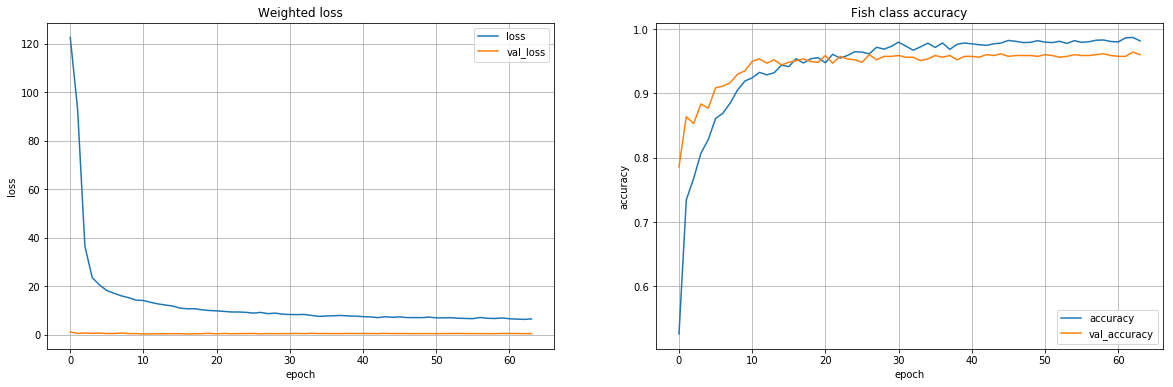

In [230]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.title('Weighted loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_class_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(122)
plt.title('Fish class accuracy')
plt.plot(history.history['class_acc'], label='accuracy')
plt.plot(history.history['val_class_acc'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.show()

In [231]:
import copy

def create_rect_xywh(box, color='red'):
    return plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                         color=color, fill=False, linewidth=2)

def show_box(idx):
    bb = X_valid[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

def to_plot(img):
    return np.rollaxis(img, 0, 3).astype(np.uint8)

def plot(img):
    x = copy.copy(img)
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    plt.imshow(np.array(x, dtype=np.uint8))

def show_predicted_box(model, i):
    box = y_box[test_idx][i]
    prediction = model.predict(np.expand_dims(X_feat[test_idx][i], axis=0))
    box_pred = prediction[0][0]
    plt.figure(figsize=(4.5, 6))
    plot(X[test_idx][i])
    ax = plt.gca()
    
    tmp = np.reshape(box_pred, (4, 4))
    for item in tmp:   
        if item[2] > 0 and item[3] > 0:
            ax.add_patch(create_rect_xywh(item, 'yellow'))

    tmp = np.reshape(box, (4, 4))
    for item in tmp:
        ax = plt.gca()
        if item[2] > 0 and item[3] > 0:
            ax.add_patch(create_rect_xywh(item, 'red'))

In [232]:
# show_predicted_box(model, 2)
pred = model.predict(X_feat[test_idx])

129
class:  ALB
mse:  72110.7734375
orig boxes:  [384 220 438 282 334 304 413 438   0   0   0   0   0   0   0   0]
pred boxes:  [329 292 409 414 331 179 389 267   4  -5   1  -7   1   0  -1  -1]


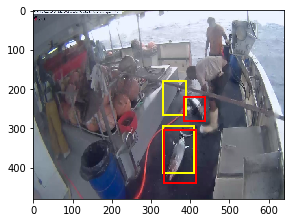

In [236]:
diff = np.array(pred[0], dtype=np.float32) - y_box[test_idx]
mse = np.empty((len(pred[0]),))
for i in range(len(pred[0])):
    mse[i] = np.dot(diff[i], diff[i])
sorted_mse = np.argsort(mse)

idxs = []
for idx, item in enumerate(y_box[test_idx]):
    if item[4] > 0:
        idxs.append(idx)
print(len(idxs))

def plot_fish_and_boxes(idx):
    # idx = sorted_mse[idx]
    show_predicted_box(model, idx)
    print('class: ', classes[np.argmax(pred[1][idx])])
    print('mse: ', mse[idx])
    print('orig boxes: ', np.array(y_box[test_idx][idx], dtype=np.int32))
    print('pred boxes: ', np.array(pred[0][idx], dtype=np.int32))
    
plot_fish_and_boxes(idxs[100])

Scale factors (x, y):  0.5 0.6666666666666666


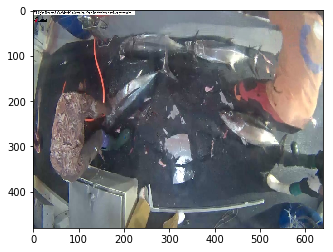

In [223]:
img = image.load_img('train/ALB/img_00003.jpg')
x_scale = float(img_w) / float(img.width)
y_scale = float(img_h) / float(img.height)
print('Scale factors (x, y): ', x_scale, y_scale)
img = img.resize((img_w, img_h))
np.shape(img)
plt.figure()
plt.imshow(img)

In [182]:
def load_test_data(path):
    X_test = []
    Id_test = []
    t0 = time.time()

    image_paths = glob.glob(os.path.join(path, '*.jpg'))
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(img_w, img_h))
        x = image.img_to_array(img)
        X_test.append(x)
        Id_test.append(os.path.basename(image_path))

    X_test = np.array(X_test)
    X_test = preprocess_input(X_test)
    t1 = time.time()
    print('Test data shape:', X_test.shape)
    print('Reading finished: {} seconds'.format(round(t1 - t0, 2)))
    return X_test, Id_test


def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()


def create_submission(ids, predictions, info):
    result = pd.DataFrame(predictions, columns=classes)
    result.loc[:, 'image'] = pd.Series(ids, index=result.index)
    now = datetime.datetime.now()
    sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    result.to_csv(sub_file, index=False)

    
def run_cross_validation_process_test(path, info_string, models):
    test_predictions = []
    X_test, id_test = load_test_data(path)

    for i in range(len(models)):
        print('Testing model # {}/{}'.format(i + 1, len(models)))
        model_prediction = models[i].predict(X_test,
                                             batch_size=batch_size,
                                             verbose=1)
        print(np.shape(np.array(model_prediction[1])))
        test_predictions.append(model_prediction[1])
    print(test_predictions)
    y_pred = merge_several_folds_mean(test_predictions, len(models))
    create_submission(id_test,
                      y_pred,
                      'loss_' + info_string + '_folds_' + str(len(models)))

In [95]:
X_test, Id_test = load_test_data('test_stg1')

Test data shape: (1000, 224, 224, 3)
Reading finished: 7.08 seconds


In [97]:
model_prediction = model.predict(X_test, batch_size=batch_size, verbose=1)

1000/1000 [==============================] - 6s     


[  2.20342837e-02   5.78626555e-07   4.10089854e-07   2.11156726e-06
   3.19603487e-07   5.50293422e-04   1.14898931e-07   1.43171846e-07]
[ 127.49950409   97.30482483  156.12095642  144.2124176    -0.38905206
   -3.87932634   -0.62381983   -5.39901924    3.55986404    0.91177821
    4.86287165    2.98226738    1.12638783    1.04122531    2.2451632
    2.01556349]
[ 52.90436935  50.02804565  69.37062073]
alma


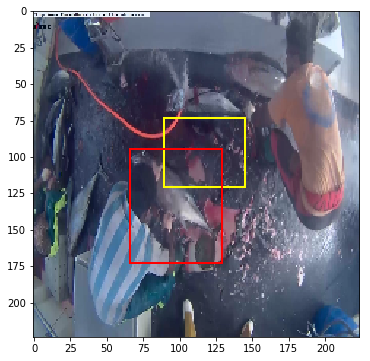

In [127]:
np.sum(model_prediction[1][0])
print(model_prediction[1][0])
print(model_prediction[0][0])
show_predicted_box(model, 0)

for item in y[train_idx]:
    if not np.sum(item) == 1:
        print(item)
print('alma')

In [20]:
run_cross_validation_process_test('test_stg1', 'fastai_course_model_1', [model])

Test data shape: (1000, 224, 224, 3)
Reading finished: 6.93 seconds
Testing model # 1/1
1000/1000 [==============================] - 7s     
(1000, 8)
[array([[  8.51089060e-02,   1.11372047e-03,   2.13342719e-03, ...,
 

In [27]:
e = [model.evaluate(X[test_idx], [y_box[test_idx], y[test_idx]]) for i in range(3)]


756/756 [==============================] - 4s     

In [34]:
d = {}
for i in range(3):
    d.update(dict(zip(model.metrics_names, e[i])))
d

{'loss': [0.61240141795425818,
  355.9236902307581,
  0.25647771704779376,
  0.70105820168893807,
  0.96296296264759451]}